In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Load the data
df = pd.read_csv('matches.csv')



In [3]:
df.info

<bound method DataFrame.info of       Unnamed: 0        date   time            comp         round  day venue  \
0              1  2021-08-15  16:30  Premier League   Matchweek 1  Sun  Away   
1              2  2021-08-21  15:00  Premier League   Matchweek 2  Sat  Home   
2              3  2021-08-28  12:30  Premier League   Matchweek 3  Sat  Home   
3              4  2021-09-11  15:00  Premier League   Matchweek 4  Sat  Away   
4              6  2021-09-18  15:00  Premier League   Matchweek 5  Sat  Home   
...          ...         ...    ...             ...           ...  ...   ...   
1384          38  2021-05-02  19:15  Premier League  Matchweek 34  Sun  Away   
1385          39  2021-05-08  15:00  Premier League  Matchweek 35  Sat  Home   
1386          40  2021-05-16  19:00  Premier League  Matchweek 36  Sun  Away   
1387          41  2021-05-19  18:00  Premier League  Matchweek 37  Wed  Away   
1388          42  2021-05-23  16:00  Premier League  Matchweek 38  Sun  Home   

     re

In [4]:
list(df.columns)

['Unnamed: 0',
 'date',
 'time',
 'comp',
 'round',
 'day',
 'venue',
 'result',
 'gf',
 'ga',
 'opponent',
 'xg',
 'xga',
 'poss',
 'attendance',
 'captain',
 'formation',
 'referee',
 'match report',
 'notes',
 'sh',
 'sot',
 'dist',
 'fk',
 'pk',
 'pkatt',
 'season',
 'team']

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


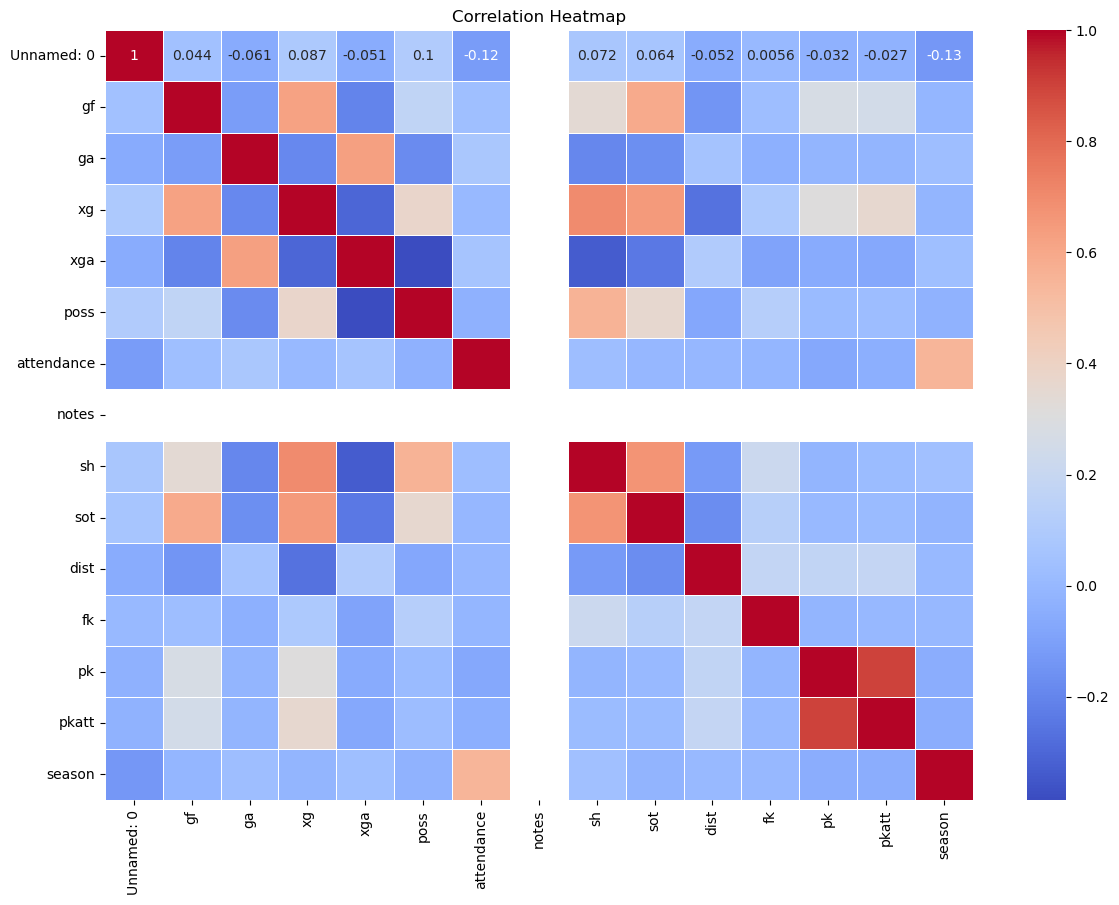

In [6]:
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(14,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:

def decide_winner(row):
    if row['result'] == 'W':
        return 'Home' if row['venue'] == 'Home' else 'Away'
    elif row['result'] == 'L':
        return 'Away' if row['venue'] == 'Home' else 'Home'
    else:
        return 'Draw'

df['winner'] = df.apply(decide_winner, axis=1)




In [8]:
print(df[['winner', 'venue', 'result']].head())  

  winner venue result
0   Home  Away      L
1   Home  Home      W
2   Home  Home      W
3   Away  Away      W
4   Draw  Home      D


In [9]:
df = df[['team', 'opponent', 'venue',
         'gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'winner']]

# Drop missing values
df.dropna(subset=['team', 'opponent', 'venue'], inplace=True)



/var/folders/yc/q8tf47yn2mdf98tzdbjm0cwc0000gn/T/ipykernel_30629/211389336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['team', 'opponent', 'venue'], inplace=True)


In [10]:
df.dtypes

team         object
opponent     object
venue        object
gf          float64
ga          float64
xg          float64
xga         float64
poss        float64
sh          float64
sot         float64
dist        float64
fk          float64
pk          float64
pkatt       float64
winner       object
dtype: object

In [11]:
# Categorical columns
categorical_features = ['team', 'opponent', 'venue']

# Numerical columns
numerical_features = ['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

In [ ]:


X = df.drop('winner', axis=1)
y = df['winner']
X = X.fillna(0)


# 2. Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
df['winner']

0       Home
1       Home
2       Home
3       Away
4       Draw
        ... 
1384    Home
1385    Away
1386    Away
1387    Home
1388    Home
Name: winner, Length: 1389, dtype: object

In [14]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['team', 'opponent',
                                                   'venue']),
                                                 ('num', StandardScaler(),
                                                  ['gf', 'ga', 'xg', 'xga',
                                                   'poss', 'sh', 'sot', 'dist',
                                                   'fk', 'pk', 'pkatt'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [15]:
print(model.score(X_test, y_test))

0.9460431654676259


Logistic Regression

In [16]:
log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)

# 5. Evaluate
print(log_model.score(X_test, y_test))

0.35611510791366907


SVM

In [17]:
from sklearn.svm import SVC
svg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

svg_model.fit(X_train, y_train)
print(svg_model.score(X_test, y_test))


0.7913669064748201


knn

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

knn_model.fit(X_train, y_train)
print(knn_model.score(X_test, y_test))


0.7266187050359713


best_model

In [19]:
import joblib

#Random Forest pipeline model
joblib.dump(model, 'rand_model.pkl')


['rand_model.pkl']